## Transformer Training
This notebook sets up a basic Transformer model for use in this project.

In [88]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Toy Problem
Setting up a toy time series binary classification problem. Generating a dataloader that contains univariate time series that is either linear or log.

In [90]:
def generate_data(length):
    X_data = []
    y_data = []
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.linspace(0+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(1)
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.geomspace(0.0000001+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(0)
    
    tensor_x = torch.Tensor(X_data).to(device)
    tensor_y = torch.Tensor(y_data).to(device)
    
    return DataLoader(TensorDataset(tensor_x, tensor_y), batch_size=64, shuffle=True)

In [91]:
trainloader = generate_data(500)
example = next(iter(trainloader))

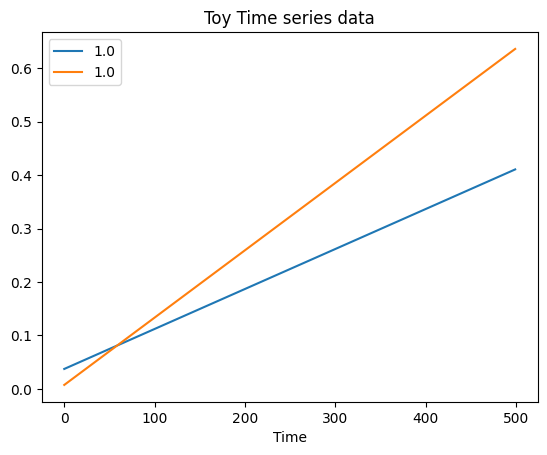

In [92]:
plt.title("Toy Time series data")
plt.plot(example[0][3].cpu(), label=example[1][3].item())
plt.plot(example[0][0].cpu(), label=example[1][0].item())
plt.xlabel("Time")
plt.legend()

### Hyperparameter Config

In [93]:
config = {
    'length': 500
}

### Transformer Model Architecture

In [94]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.length = config['length']
        self.positional_embed = nn.Parameter(torch.randn(self.length))
        
        self.transformer_blocks = nn.Transformer(d_model=self.length, nhead=5)
        self.classification_head = nn.Linear(self.length, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x + self.positional_embed
        z = self.transformer_blocks(x, x)
        z = self.classification_head(z)
        return self.sigmoid(z.squeeze(1))

### Training Loop

In [95]:
objective = nn.BCELoss()

tran = Transformer(config).to(device)

lr = 1e-5
n_epochs = 10
optim = torch.optim.Adam(tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        optim.zero_grad()
        yhat = tran(X)
        loss = objective(yhat, y)
        loss.backward()
        losses.append(loss.item())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.40it/s]


Epoch: 1 Loss: 0.6921872496604919


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.42it/s]


Epoch: 2 Loss: 0.6774537563323975


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.30it/s]


Epoch: 3 Loss: 0.5929237008094788


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.30it/s]


Epoch: 4 Loss: 0.10688534379005432


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch: 5 Loss: 0.14258381724357605


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch: 6 Loss: 0.035846639424562454


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.44it/s]


Epoch: 7 Loss: 0.08776262402534485


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.41it/s]


Epoch: 8 Loss: 0.030411558225750923


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.44it/s]


Epoch: 9 Loss: 0.04852983355522156


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.40it/s]

Epoch: 10 Loss: 0.08210299164056778


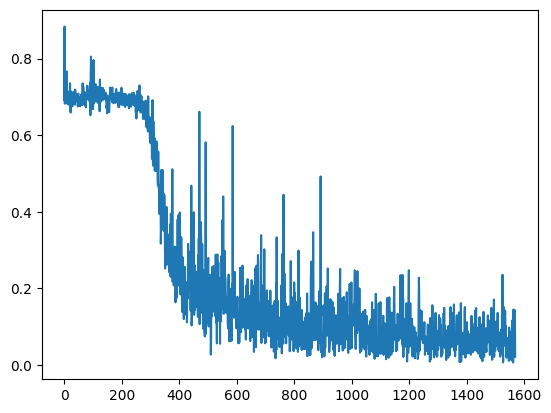

In [96]:
plt.plot(losses)

### Evaluate Training Accuracy

In [97]:
with torch.no_grad():
    correct = 0
    N = 0
    
    for i, (X, y) in enumerate(tqdm(trainloader)):
        probs = tran(X)
        preds = torch.round(probs)
        
        correct += (preds == y).sum().item()
        N += y.shape[0]
        
    print("Train Accuracy: ", correct/N)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.97it/s]

Train Accuracy:  0.9732
